# Function Approximation and DDQN

In the last 2 labs, we have tried Temporal difference in Q-learning and SARSA and upgrade the Q-learning using deep learning to be DQN. For both labs, there is a problem about TD algorithm that is is not dufficiently scalable for problem in many states/actions. We need to scale the states/actions as discreted states/actions. However, it is extremely slow at learning too many values for individual pairs of states and actions, and it is not accurated.

This lab will improve TD method using function approximation. After try to implement in TD method, we will upgrade it using DQN and improve the performance using DDQN.

## Function Approximation

The TD method can learn the Q-function during an episode but is not scalable. For example, the number of states in a chess game is around 1,040, and 1,070 in a Go game. Moreover, it seems infeasible to learn the values for continuous state using the TD method. Hence, we need to solve such problems using **function approximation (FA)**, which approximates the state space using a set of features.

Function approximation is an algorithm by approximating Q-functions using linear functions and gradient descent. The main idea of **FA** is to use a set of **features** to estimate **Q** values. This is extremely useful for processes with a large state space where the Q table becomes huge. There are several ways to map the features to the Q values; for example, linear approximations that are linear combinations of features and neural networks. With linear approximation, the state-value function for an action is expressed by a weighted sum of the features:

$$V(s)=\theta_1 F_1(s) + \theta_2 F_2(s) + \cdots + \theta_n F_n(s)$$

By given $F_1, F_2, \cdots, F_n$ are set of features given the input state $s$, and $\theta_1, \theta_2, \cdots, \theta_n$ are the weights applied to corresponding features. Thus, we can summarize the function as:

$$V(s) = \theta F(s)$$

As we known, in the TD method, both Q-learning and SARSA can be written as:

$$V(s_t)=V(s_t)+\alpha[r + \gamma V(s_{t+1}) - V(s_t)]$$

By assume $\delta$ as the TD error term, we can do as the following:

$$\delta = r + \gamma V(s_{t+1}) - V(s_t)$$

Hence,

$$V(s_t)=V(s_t)+\alpha \delta$$

This is in the **exact form of gradient descent**. Hence, the **goal of learning** is to **find the optimal weights, $\theta$, to best approximate the state-value function $V(s)$ for each possible action**. The loss function in this case is minimize loss that similar to the regression problem, which is the mean squared error between the actual value and the estimated value. After each step in an episode, we have a new estimation of the true state value, and we move the weights, $\theta$, a step toward their optimal value.

The feature set, $F(s)$, given the input state, $s$. A good feature set is one that can capture the dynamics of different inputs. Typically, we can generate a set of features with a set of Gaussian functions under various parameters, including mean and standard deviation.

## Function approximation example: Mountain car

Mountain Car (https://gym.openai.com/envs/MountainCar-v0/) is a typical Gym environment with continuous states. As shown in the following diagram, its goal is to get the car to the top of the hill:

<img src="img/mountaincar.png" title="mountaincar" style="width: 400px;" />

On a one-dimensional track, the car is positioned between -1.2 (leftmost) and 0.6 (rightmost), and the goal (yellow flag) is located at 0.5. The engine of the car is not strong enough to drive it to the top in a single pass, so it has to drive back and forth to build up momentum. Hence, there are three discrete actions for each step:

- 0: Push left
- 1: No push
- 2: Push right

And there are two states of the environment:

- Position of the car: continuous variable of range $[-1.2, 0.6]$.
- Velocity of the car: continuous variable of range $[-0.07, 0.07$

The reward associated with each step is -1, until the car reaches the goal (a position of 0.5).

An episode ends when the car reaches the goal position (obviously), or after 200 steps.

### Starting the code

Same as every lab, create the mountaincar environment

In [9]:
import numpy as np
import random
import gym
import math
import torch
from collections import defaultdict, deque
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [2]:
env = gym.envs.make("MountainCar-v0")
n_action = env.action_space.n
print(n_action)

3


Take a look the state

state: [-0.49905324  0.        ]
Position:  -0.49905324
Velocity:  0.0


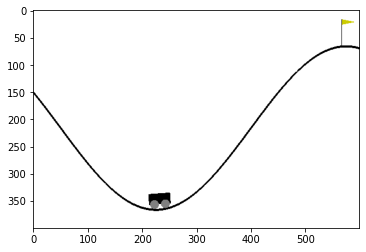

In [3]:
state = env.reset()
print("state:", state)
print("Position: ", state[0])
print("Velocity: ", state[1])
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

The car starts with the <code>state</code>, which means that the initial position is around -0.5 and the velocity is 0. You may see a different initial position as it is randomly generated from -0.6 to -0.4.

Let's take a naive approach now: we just keep pushing the car to the right and hope it will reach the top:

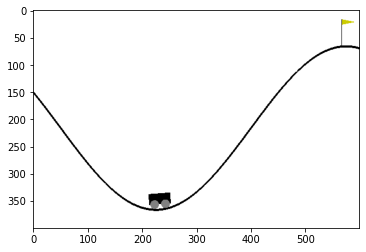

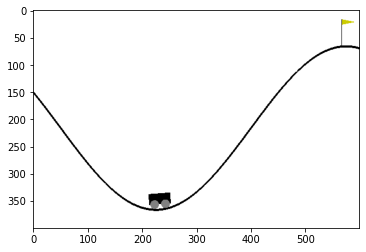

In [5]:
is_done = False
while not is_done:
    next_state, reward, is_done, info = env.step(2)
    print(next_state, reward, is_done)
    screen = env.render(mode='rgb_array')

    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

The state keeps changing accordingly and the reward is -1 for each step.

You will also see that the car is repeatedly moving to the right and back to the left, but doesn't reach the top in the end.

As you can imagine, the Mountain Car problem is not as easy as you thought. We need to drive the car back and forth to build up momentum. And the state variables are continuous, which means that a table lookup/update method (such as the TD method) will not work. In the next recipe, we will solve the Mountain Car problem with FA methods.

### Estimating Q-functions with gradient descent approximation

Then let develot the Q-function approximator based on the linear function as:

In [3]:
from torch.autograd import Variable

class Estimator():
    def __init__(self, n_feat, n_state, n_action, lr=0.05):
        self.w, self.b = self.get_gaussian_wb(n_feat, n_state)
        self.n_feat = n_feat
        self.models = []
        self.optimizers = []
        self.criterion = torch.nn.MSELoss()

        for _ in range(n_action):
            model = torch.nn.Linear(n_feat, 1)
            self.models.append(model)
            optimizer = torch.optim.SGD(model.parameters(), lr)
            self.optimizers.append(optimizer)


    def get_gaussian_wb(self, n_feat, n_state, sigma=.2):
        """
        Generate the coefficients of the feature set from Gaussian distribution
        @param n_feat: number of features
        @param n_state: number of states
        @param sigma: kernel parameter
        @return: coefficients of the features
        """
        torch.manual_seed(0)
        w = torch.randn((n_state, n_feat)) * 1.0 / sigma
        b = torch.rand(n_feat) * 2.0 * math.pi
        return w, b

    def get_feature(self, s):
        """
        Generate features based on the input state
        @param s: input state
        @return: features
        """
        features = (2.0 / self.n_feat) ** .5 * torch.cos(
            torch.matmul(torch.tensor(s).float(), self.w) + self.b)
        return features


    def update(self, s, a, y):
        """
        Update the weights for the linear estimator with the given training sample
        @param s: state
        @param a: action
        @param y: target value
        """
        features = Variable(self.get_feature(s))
        y_pred = self.models[a](features)

        loss = self.criterion(y_pred, Variable(torch.Tensor([y])))

        self.optimizers[a].zero_grad()
        loss.backward()
        self.optimizers[a].step()

    def predict(self, s):
        """
        Compute the Q values of the state using the learning model
        @param s: input state
        @return: Q values of the state
        """
        features = self.get_feature(s)
        with torch.no_grad():
            return torch.tensor([model(features) for model in self.models])

#### Initialize function

In the initialize function, it takes in three parameters:
- the number of features, n_feat
- the number of states
- the number of actions

It first generates a set of coefficients, $w$ and $b$, for the feature function $F(s)$ from Gaussian distributions, which we will define later. It then initializes n_action linear models, where each model corresponds to an action, and n_action optimizers, accordingly. For the linear model, we herein use the Linear module from PyTorch. It takes in <code>n_feat</code> units and generates one output, which is the predicted state-value for an action.

The stochastic gradient descent optimizer is also initialized along with each linear model. The learning rate for each optimizer is 0.05. The loss function is the mean squared error.

#### get_gaussian_wb function

The <code>get_gaussian_wb</code> can generate a set of coefficients, $w$ and $b$, for the feature function, $F(s)$. The coefficient $w$ is an <code>n_feat</code> by <code>n_state</code> matrix, with values generated from a Gaussian distribution of variance defined by the parameter sigma; the bias $b$ is a list of <code>n_feat</code> values generated from a uniform distribution of $[0, 2\pi]$. The feature of a state $s$ is generated as follows:

$$F(s)=\sqrt{\frac{2}{n_{feat}}}\cos (ws+b)$$

Note that we use cosine to make sure that the output must between $[-1,1]$ all the states input

#### get_feature function

Since we've defined model and feature generation, we now develop the training method, which updates the linear models with a **data point**.

Given a training data point, it first converts the state to feature space with the get_feature method. The resulting features are then fed into the current linear model of the given action $a$. The predictive result, along with the target value, is used to compute the loss and gradients. The weights $\theta$ are then updated via backpropagation.

#### predict function

Compute the Q values of the state using the learning model.

### Test the estimator class

Try to use the code with some dummy data as these steps

1. Create an Estimator object that maps a 2-dimensional state to a 10-dimensional feature and works with 1 possible action
2. Generate the feature out of a state [0.5, 0.1]. You can see the result feature is a 10-dimentional vector.
3. Use the trained linear model to predict the value for new states.

In [7]:
estimator = Estimator(10, 2, 1)

s1 = [0.5, 0.1]
print(estimator.get_feature(s1))

print(estimator.predict([0.5, 0.1]))
print(estimator.predict([2, 3]))

tensor([ 0.3163, -0.4467, -0.0450, -0.1490,  0.2393, -0.4181, -0.4426,  0.3074,
        -0.4451,  0.1808])
tensor([-0.2063])
tensor([0.0485])


### In summary

The FA method approximates the state values with a more compact model than computing the exact values with a Q table in the TD method. FA first maps the state space to the feature space and then estimates the Q values using a regression model. In this way, the learning process becomes supervised. Type regression models include linear models and neural networks. In this recipe, we developed an estimator based on linear regression. It generates features according to coefficients sampled from a Gaussian distribution. It updates the weights for the linear model given training data via gradient descent and predicts Q values given a state.

FA dramatically reduces the number of states to learn, where learning millions of states is not feasible in the TD method. More importantly, it is able to generalize to unseen states, as the state-values are parameterized by the estimation functions given input states.

### Q-learning with linear function approximation

After we have developed a value estimator based on linear regression. We will employ the **estimator class** in Q-learning, as part of FA.

As we have seen, Q-learning is an off-policy learning algorithm and it updates the Q-function based on the following equation:

$$Q(s,a)=Q(s,a)+\alpha [r + \gamma \max_{a'}Q(s',a') - Q(s,a)]$$

among those in state $s'$ is selected to generate learning data. In Q-learning, actions are taken on the basis of the epsilon-greedy policy. Thus, Q-learning with FA can approximate the error term as:

$$\delta= r + \gamma V(s_{t+1})-V(s_t) = r + \gamma \max_{a'}V(s') - V(s_t)$$

The goal is to minimize the error term to zero. Thus, the estimate $V(s_t)$ or $Q(s,a)$ can be derived as the equation:

$$V(s_t) = r + \gamma \max_{a'}V(s')$$

Now, the goal becomes finding the optimal weights $\theta$ as in $V(s)=\theta F(s)$, to best approximate the state-value function $V(s)$ for each possible action. The loss function we are trying to minimize in this case is similar to that in a regression problem, which is the mean squared error between the actual value and the estimated value.

#### Create the epsilon greedy policy

In [4]:
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
        probs = torch.ones(n_action) * epsilon / n_action
        q_values = estimator.predict(state)
        best_action = torch.argmax(q_values).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        return action
    return policy_function

#### Define the Q-learning function with FA

The <code>q_learning</code> function must do the following tasks:

- Creates an epsilon-greedy policy with an epsilon factor decayed to 99% (for example, if epsilon in the first episode is 0.1, it will be 0.099 in the second episode).
- In each step, takes an action $a$ in keeping with the epsilon-greedy policy, and computes the Q values of the new state using the current estimator, then, computes the target value $V(s_t)=r+\gamma \max_{a'}V(s')$ and uses it to train the estimator.
- Runs n_episodes and records the total reward for each episode.

In [5]:
def q_learning(env, estimator, n_episode, gamma=1.0, epsilon=0.1, epsilon_decay=.99):
    """
    Q-Learning algorithm using Function Approximation
    @param env: Gym environment
    @param estimator: Estimator object
    @param n_episode: number of episodes
    @param gamma: the discount factor
    @param epsilon: parameter for epsilon_greedy
    @param epsilon_decay: epsilon decreasing factor
    """
    for episode in range(n_episode):
        policy = gen_epsilon_greedy_policy(estimator, epsilon * epsilon_decay ** episode, n_action)
        state = env.reset()
        is_done = False

        while not is_done:
            action = policy(state)
            next_state, reward, is_done, _ = env.step(action)

            q_values_next = estimator.predict(next_state)           ## Use estimator here
            td_target = reward + gamma * torch.max(q_values_next)

            estimator.update(state, action, td_target)
            total_reward_episode[episode] += reward

            if is_done:
                break
            state = next_state

We specify the number of features as 200 and the learning rate as 0.03, and create an estimator accordingly:

In [10]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_feature = 200
lr = 0.03
estimator = Estimator(n_feature, n_state, n_action, lr)

Setup Q-learning with FA for 300 episodes and also keep track of the total rewards for each episode:

In [11]:
n_episode = 300
total_reward_episode = [0] * n_episode

q_learning(env, estimator, n_episode, epsilon=0.1)

Then plot the graph to see the result over time.

As you can see, in Q-learning with FA, it tries to learn the optimal weights for the approximation models so that the Q values are best estimated. It is similar to TD Q-learning in the sense that they both generate learning data from another policy. It is more suitable for environments with large state space as the Q values are approximated by a set of regression models and latent features, while TD Q-learning requires exact table lookup to update the Q values. The fact that Q-learning with FA updates the regression models after every single step also makes it similar to the TD Q-learning method.

After the Q-learning model is trained, we just need to use the regression models to predict the state-action values for all possible actions and pick the action with the largest value given a state.

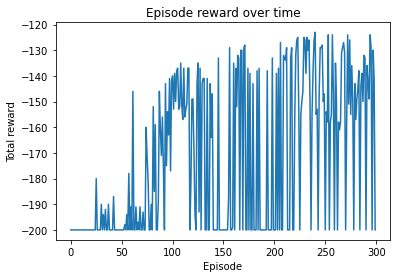

In [12]:
import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

### Incorporating batching using experience replay

Now we add the experience replay same as DQN.

**Experience replay** means we store the agent's experiences during an episode instead of running Q-learning. The learning phase with experience replay becomes two phases: gaining experience and updating models based on the experience obtained after an episode finishes.Specifically, the experience (also called the buffer, or memory) includes the past state, the action taken, the reward received, and the next state for individual steps in an episode.

Let's modify <code>q_learning</code> function, and add tasks:

- After each episode, randomly selects replay_size samples from the buffer memory and uses them to train the estimator.

In [6]:
import random

def q_learning(env, estimator, n_episode, replay_size, gamma=1.0, epsilon=0.1, epsilon_decay=.99):
    """
    Q-Learning algorithm using Function Approximation, with experience replay
    @param env: Gym environment
    @param estimator: Estimator object
    @param replay_size: number of samples we use to update the model each time
    @param n_episode: number of episodes
    @param gamma: the discount factor
    @param epsilon: parameter for epsilon_greedy
    @param epsilon_decay: epsilon decreasing factor
    """
    for episode in range(n_episode):
        if (episode + 1) % 50 == 0:
            print("trainin episode:", episode + 1)
        policy = gen_epsilon_greedy_policy(estimator, epsilon * epsilon_decay ** episode, n_action)
        state = env.reset()
        is_done = False
        while not is_done:
            action = policy(state)
            next_state, reward, is_done, _ = env.step(action)
            total_reward_episode[episode] += reward

            if is_done:
                break

            q_values_next = estimator.predict(next_state)
            td_target = reward + gamma * torch.max(q_values_next)

            memory.append((state, action, td_target))    # record experience here

            state = next_state

        replay_data = random.sample(memory, min(replay_size, len(memory))) # replay to learn here

        for state, action, td_target in replay_data:
            estimator.update(state, action, td_target)

Now, let's training

In [14]:
memory = deque(maxlen=300)

n_episode = 1000
replay_size = 200
total_reward_episode = [0] * n_episode

q_learning(env, estimator, n_episode, replay_size, epsilon=0.1)

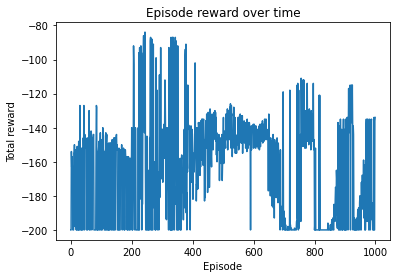

In [15]:
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

You can see that the performance of Q-learning with experience replay becomes much more stable. The rewards in most episodes after the first 500 episodes stay in the range of -160 to -120.

In this recipe, we solved the Mountain Car problem with the help of FA Q-learning, along with experience replay. It outperforms pure FA Q-learning because we collect less corrected training data with experience replay. Instead of rushing in and training the estimator, we first store the data points we observe during episodes in a buffer, and then we randomly select a batch of samples from the buffer and train the estimator. This forms an input dataset where samples are more independent of one another, thereby making training more stable and efficient.

Now, we think that the result is good enough, let's simulate it.

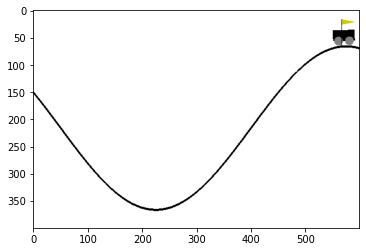

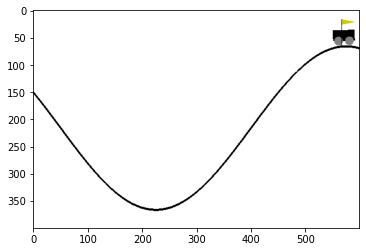

In [16]:
acts = ["left", "no action", "right"]
is_done = False
state = env.reset()
while not is_done:
    q_values = estimator.predict(state)
    action = torch.argmax(q_values).item()
    
    state, reward, is_done, info = env.step(action)
    print("take action: ", acts[action])
    print(state, reward, is_done)
    screen = env.render(mode='rgb_array')

    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

### Q-learning with neural network function approximation

The goal of FA is to use a set of features to estimate the Q values via a regression model. Using neural networks as the estimation model, we increase the regression power by adding flexibility (multiple layers in neural networks) and non-linearity introduced by non-linear activation in hidden layers. The remaining part of the Q-learning model is very similar to the one with linear approximation. We also use gradient descent to train the network. The ultimate goal of learning is to find the optimal weights of the network to best approximate the state-value function, V(s), for each possible action. The loss function we are trying to minimize is also the mean squared error between the actual value and the estimated value.

Now, modify the estimator class.

In [7]:
class Estimator():
    def __init__(self, n_feat, n_state, n_action, n_hidden=50, lr=0.05, device = "cpu"):
        self.w, self.b = self.get_gaussian_wb(n_feat, n_state)
        self.n_feat = n_feat
        self.models = []
        self.optimizers = []
        self.criterion = torch.nn.MSELoss()
        self.device = device

        for _ in range(n_action):
            model = torch.nn.Sequential(
                        torch.nn.Linear(n_feat, n_hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(n_hidden, 1)
                ).to(device)

            self.models.append(model)
            optimizer = torch.optim.Adam(model.parameters(), lr)
            self.optimizers.append(optimizer)



    def get_gaussian_wb(self, n_feat, n_state, sigma=.2):
        """
        Generate the coefficients of the feature set from Gaussian distribution
        @param n_feat: number of features
        @param n_state: number of states
        @param sigma: kernel parameter
        @return: coefficients of the features
        """
        torch.manual_seed(0)
        w = torch.randn((n_state, n_feat)) * 1.0 / sigma
        b = torch.rand(n_feat) * 2.0 * math.pi
        return w, b

    def get_feature(self, s):
        """
        Generate features based on the input state
        @param s: input state
        @return: features
        """
        features = (2.0 / self.n_feat) ** .5 * torch.cos(
            torch.matmul(torch.tensor(s).float(), self.w) + self.b)
        return features.to(self.device)


    def update(self, s, a, y):
        """
        Update the weights for the linear estimator with the given training sample
        @param s: state
        @param a: action
        @param y: target value
        """
        features = Variable(self.get_feature(s))


        y_pred = self.models[a](features)

        loss = self.criterion(y_pred, Variable(torch.Tensor([y]).to(self.device)))

        self.optimizers[a].zero_grad()
        loss.backward()

        self.optimizers[a].step()



    def predict(self, s):
        """
        Compute the Q values of the state using the learning model
        @param s: input state
        @return: Q values of the state
        """
        features = self.get_feature(s)
        with torch.no_grad():
            return torch.tensor([model(features) for model in self.models])

Then, train it.

In [25]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_feature = 200
n_hidden = 50
lr = 0.001
estimator = Estimator(n_feature, n_state, n_action, n_hidden, lr)

In [26]:
memory = deque(maxlen=300)

n_episode = 1000
replay_size = 200
total_reward_episode = [0] * n_episode

q_learning(env, estimator, n_episode, replay_size, epsilon=0.1)

In [ ]:
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

And simulate it.

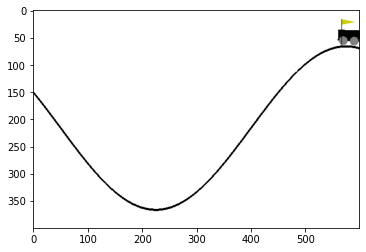

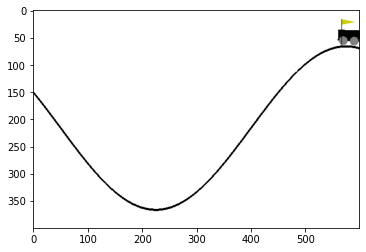

In [21]:
acts = ["left", "no action", "right"]
is_done = False
state = env.reset()
while not is_done:
    q_values = estimator.predict(state)
    action = torch.argmax(q_values).item()
    
    state, reward, is_done, info = env.step(action)
    print("take action: ", acts[action])
    print(state, reward, is_done)
    screen = env.render(mode='rgb_array')

    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

### Solving the 2-DOF invert pendulum swing up with function approximation

We tried to use the Acrobot environment using the same estimator class. The states and action as follow:

#### Action Space
The action is discrete, deterministic, and represents the torque applied on the actuated
joint between the two links.

| Num | Action                                             | Unit               |
|----|-------------------------------------------|---------------|
| 0   | apply -1 torque to the actuated joint | torque (N m) |
| 1   | apply 0 torque to the actuated joint  | torque (N m) |
| 2   | apply 1 torque to the actuated joint  | torque (N m) |

#### Observation Space
The observation is a `ndarray` with shape `(6,)` that provides information about the
two rotational joint angles as well as their angular velocities:

| Num | Observation           | Min                  | Max                |
|-----|-----------------------|----------------------|--------------------|
| 0   | Cosine of `theta1`         | -1                 | 1                |
| 1   | Sine of `theta1`         | -1                 | 1                |
| 2   | Cosine of `theta2`            | -1 | 1 |
| 3   | Sine of `theta2`            | -1 | 1 |
| 4   | Angular velocity of `theta1` |        ~ -12.567 (-4 * pi)         |      ~ 12.567 (4 * pi)   |
| 5   | Angular velocity of `theta2` |        ~ -28.274 (-9 * pi)         |      ~ 28.274 (9 * pi)   |

In [8]:
env = gym.envs.make("Acrobot-v1")

n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_feature = 600
n_hidden = 200
lr = 0.001
# if you have only 1 gpu, let's use cuda or cuda:0
estimator = Estimator(n_feature, n_state, n_action, n_hidden, lr, "cuda:1")
estimator = estimator

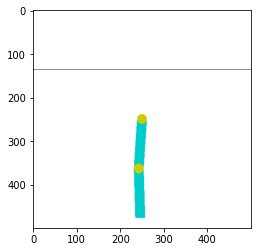

In [9]:
state = env.reset()
screen = env.render(mode='rgb_array')
plt.imshow(screen)

In [9]:
memory = deque(maxlen=300)

n_episode = 1500
replay_size = 250
total_reward_episode = [0] * n_episode

q_learning(env, estimator, n_episode, replay_size, epsilon=0.1)

trainin episode: 50
trainin episode: 100
trainin episode: 150
trainin episode: 200
trainin episode: 250
trainin episode: 300
trainin episode: 350
trainin episode: 400
trainin episode: 450
trainin episode: 500
trainin episode: 550
trainin episode: 600
trainin episode: 650
trainin episode: 700
trainin episode: 750
trainin episode: 800
trainin episode: 850
trainin episode: 900
trainin episode: 950
trainin episode: 1000
trainin episode: 1050
trainin episode: 1100
trainin episode: 1150
trainin episode: 1200
trainin episode: 1250
trainin episode: 1300
trainin episode: 1350
trainin episode: 1400
trainin episode: 1450
trainin episode: 1500


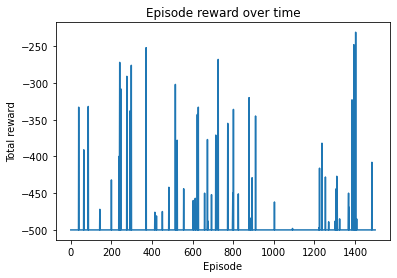

In [10]:
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

In [14]:
import os
from gym.wrappers import Monitor

vdo_path = 'video_rl/'
if not os.path.exists(vdo_path):
  print("No folder ", vdo_path, 'exist. Create the folder')
  os.mkdir(vdo_path)
  print("Create directory finished")
else:
  print(vdo_path, 'existed, do nothing')

env = Monitor(gym.make("Acrobot-v1"), vdo_path, force=True)

acts = ["-1", "0", "1"]
is_done = False
state = env.reset()
while not is_done:
    q_values = estimator.predict(state)
    action = torch.argmax(q_values).item()
    
    state, reward, is_done, info = env.step(action)
    print("take action: ", acts[action])
    print(state, reward, is_done)
    screen = env.render(mode='rgb_array')

    # plt.imshow(screen)
    # ipythondisplay.clear_output(wait=True)
    # ipythondisplay.display(plt.gcf())
env.close()

video_rl/ existed, do nothing
take action:  -1
[ 0.9996973  -0.02460193  0.99981886  0.01903217  0.2742023  -0.3440582 ] -1.0 False
take action:  -1
[ 0.9990269   0.0441047   0.99646515 -0.08400691  0.39561558 -0.6582884 ] -1.0 False
take action:  -1
[ 0.99215186  0.12503898  0.97369933 -0.22783676  0.39569464 -0.76116407] -1.0 False
take action:  -1
[ 0.9812516   0.19273104  0.9312186  -0.36446103  0.2723545  -0.6373555 ] -1.0 False
take action:  0
[ 0.9768046   0.21413249  0.90461034 -0.42623952 -0.05872443 -0.02393638] -1.0 False
take action:  0
[ 0.9853571   0.17050327  0.9275846  -0.37361315 -0.37572777  0.58370596] -1.0 False
take action:  -1
[ 0.9963476   0.08539017  0.9684995  -0.24901558 -0.46169615  0.6941731 ] -1.0 False
take action:  -1
[ 0.99999195 -0.00401467  0.9927313  -0.12035201 -0.41116247  0.57939845] -1.0 False
take action:  -1
[ 0.99750805 -0.0705528   0.99943817 -0.03351641 -0.23874973  0.26659295] -1.0 False
take action:  -1
[ 0.99550635 -0.09469467  0.99978137 

take action:  -1
[ 0.9787956  0.2048394  0.5823165 -0.8129622  1.094639  -0.6174674] -1.0 False
take action:  0
[ 0.9287569   0.37068936  0.5730481  -0.8195217   0.6009868   0.5259948 ] -1.0 False
take action:  -1
[ 0.9020917   0.4315444   0.7208746  -0.6930655   0.04978839  1.4107052 ] -1.0 False
take action:  -1
[ 0.9211172   0.38928536  0.9177311  -0.39720228 -0.49464294  2.1057026 ] -1.0 False
take action:  -1
[ 0.96564513  0.25986445  0.9991071   0.04224873 -0.8264162   2.2946074 ] -1.0 False
take action:  -1
[ 0.9958631   0.09086672  0.89473003  0.44660744 -0.84555656  1.8150951 ] -1.0 False
take action:  1
[ 0.99649185 -0.08368966  0.695908    0.71813095 -0.86270344  1.4944248 ] -1.0 False
take action:  -1
[ 0.97640944 -0.21592721  0.55784255  0.8299468  -0.45352516  0.26096684] -1.0 False
take action:  -1
[ 0.9670465  -0.2545998   0.6218535   0.7831336   0.06958797 -1.0596398 ] -1.0 False
take action:  0
[ 0.9802596  -0.19771463  0.83165747  0.555289    0.5056087  -2.017803  ] 

take action:  0
[ 0.27674437  0.9609436   0.37733996 -0.9260748   0.26471707 -1.4684386 ] -1.0 False
take action:  1
[ 0.36067042  0.9326933   0.2640107  -0.96451974 -1.1401536   0.29158247] -1.0 False
take action:  1
[ 0.66582006  0.74611235  0.4976672  -0.86736804 -2.4234056   2.29153   ] -1.0 False
take action:  -1
[ 0.96182567  0.2736628   0.9017673  -0.43222186 -3.1288733   3.6127644 ] -1.0 False
take action:  1
[ 0.930269   -0.3668782   0.93847203  0.3453553  -3.2239928   4.025063  ] -1.0 False
take action:  -1
[ 0.6017391 -0.7986927  0.5588803  0.8292483 -2.1875892  2.1292605] -1.0 False
take action:  0
[ 0.32069474 -0.9471826   0.32704264  0.9450096  -0.980789    0.50750315] -1.0 False
take action:  -1
[ 0.2651885  -0.9641966   0.39209044  0.91992664  0.40558234 -1.1905631 ] -1.0 False
take action:  1
[ 0.4499972  -0.89303     0.6853929   0.72817343  1.5641165  -2.339179  ] -1.0 False
take action:  -1
[ 0.7877471  -0.6159988   0.98523057  0.17123295  2.776641   -4.003985  ] -1.

take action:  -1
[ 0.9990429   0.04374075  0.780864   -0.624701    2.9374433  -5.9376745 ] -1.0 False
take action:  1
[ 0.8497999   0.52710545 -0.08155714 -0.9966687   2.1337383  -3.804849  ] -1.0 False
take action:  -1
[ 0.6181034   0.7860968  -0.6373029  -0.77061343  1.3270265  -2.3218722 ] -1.0 False
take action:  -1
[ 0.47610167  0.87939024 -0.8523853  -0.5229143   0.35576874 -0.9888069 ] -1.0 False
take action:  -1
[ 0.50284934  0.8643741  -0.88638127 -0.462956   -0.6573392   0.29551017] -1.0 False
take action:  1
[ 0.6917586   0.72212887 -0.75945187 -0.6505635  -1.677751    1.9806836 ] -1.0 False
take action:  -1
[ 0.91843337  0.39557576 -0.32776403 -0.9447596  -2.2648401   3.3145046 ] -1.0 False
take action:  -1
[ 0.9970895  -0.07623975  0.44667473 -0.8946964  -2.5143123   4.6172724 ] -1.0 False
take action:  0
[ 0.83635974 -0.54818094  0.9966048  -0.08233374 -2.3900106   5.346868  ] -1.0 False
take action:  -1
[ 0.5832561  -0.8122883   0.66145736  0.7499828  -1.1785913   3.7485

take action:  1
[ 0.5484461  -0.83618593  0.778657   -0.6274498   1.3101469  -1.6267161 ] -1.0 False
take action:  -1
[ 0.8102008  -0.5861524   0.49265337 -0.8702256   2.270916   -2.0114233 ] -1.0 False
take action:  1
[ 0.9907597  -0.13562919  0.20655139 -0.97843575  2.5265937  -0.91238225] -1.0 False
take action:  -1
[ 0.93867826  0.3447943   0.15275359 -0.9882643   2.2213643   0.47194526] -1.0 False
take action:  1
[ 0.7776516   0.6286955   0.45911476 -0.88837695  0.95390123  2.7909477 ] -1.0 False
take action:  1
[ 0.75609916  0.6544571   0.9527619  -0.30371833 -0.57034683  4.933349  ] -1.0 False
take action:  -1
[ 0.8577953   0.5139914   0.76821667  0.64018995 -1.0076803   4.8013167 ] -1.0 False
take action:  0
[ 0.9449477   0.32722136 -0.00663856  0.99997795 -1.0429386   3.9994235 ] -1.0 False
take action:  -1
[ 0.9922431   0.12431244 -0.6553952   0.7552861  -1.0589674   3.1337826 ] -1.0 False
take action:  -1
[ 0.9962224  -0.08683857 -0.9567141   0.29102945 -1.0271549   2.501515

### DQN of function approximation

As you can see, the neural network function approximation is very look-a-like DQN, but there are some difference.

1. A model output is came out only 1 action way.
2. There are w and b in the class.

To implement the DQN into function approximation, you need to modify the estimator class.

In [16]:
# Epsilon annealing schedule generator

def gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay):
    eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)
    return eps_by_episode

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

class Estimator_DQN(nn.Module):
    def __init__(self, n_feat, n_state, n_action, n_hidden=50, lr=0.05, device = "cpu"):
        super(Estimator_DQN, self).__init__()  
        self.device = device
        self.w, self.b = self.get_gaussian_wb(n_feat, n_state)
        self.n_feat = n_feat
        
        self.model = torch.nn.Sequential(
                    torch.nn.Linear(n_feat, n_hidden),
                    torch.nn.ReLU(),
                    torch.nn.Linear(n_hidden, n_hidden* 2),
                    torch.nn.ReLU(),
                    torch.nn.Linear(n_hidden * 2, n_hidden),
                    torch.nn.ReLU(),
                    torch.nn.Linear(n_hidden, n_action)
            )


    def get_gaussian_wb(self, n_feat, n_state, sigma=.2):
        """
        Generate the coefficients of the feature set from Gaussian distribution
        @param n_feat: number of features
        @param n_state: number of states
        @param sigma: kernel parameter
        @return: coefficients of the features
        """
        torch.manual_seed(0)
        w = torch.randn((n_state, n_feat)) * 1.0 / sigma
        b = torch.rand(n_feat) * 2.0 * math.pi
        return w.to(self.device), b.to(self.device)

    def get_feature(self, s):
        """
        Generate features based on the input state
        @param s: input state
        @return: features
        """
        features = (2.0 / self.n_feat) ** .5 * torch.cos(
            torch.matmul(torch.tensor(s).float().to(self.device), self.w) + self.b)
        return features.unsqueeze(0).to(self.device)
    
    def forward(self, x):
        """
        Compute the Q values of the state using the learning model
        @param s: input state
        @return: Q values of the state
        """
        features = self.get_feature(x)
        
        out = self.model(features)
        return out


    def act(self, s, epsilon):
        # Get an epsilon greedy action for given state
        if random.random() > epsilon: # Use argmax_a Q(s,a)
            q_value = self.forward(s)
            q_value = q_value.cpu()
            action = q_value.max(1)[1].item()           
        else: # get random action
            action = random.randrange(env.action_space.n)
        return action

In [5]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        # Add batch index dimension to state representations
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [269]:
def compute_td_loss(model, batch_size, gamma=0.99):

    # Get batch from replay buffer
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # Convert to tensors. Creating Variables is not necessary with more recent PyTorch versions.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)

    # Calculate Q(s) and Q(s')
    q_values      = model(state).squeeze()
    #print(q_values.shape)
    next_q_values = model(next_state).squeeze()

    # Get Q(s,a) and max_a' Q(s',a')
    #print("action.unsqueeze(1)", action.unsqueeze(1))
    #print(action.unsqueeze(1).shape)
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    # Calculate target for Q(s,a): r + gamma max_a' Q(s',a')
    # Note that the done signal is used to terminate recursion at end of episode.
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # Calculate MSE loss. Variables are not needed in recent PyTorch versions.
    loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [23]:
def plot(episode, rewards, losses):
    # clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)   
    plt.show() 

In [271]:
from tqdm import trange

def train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99, device="cpu"):
    losses = []
    all_rewards = []
    episode_reward = 0
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)

    # Get initial state input
    state = env.reset()

    # Execute episodes iterations
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # Get initial epsilon greedy action
        epsilon = eps_by_episode(episode)
        action = model.act(state, epsilon)
        
        # Take a step
        next_state, reward, done, _ = env.step(action)

        # Append experience to replay buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        episode_reward += reward
        
        state = next_state

        # Start a new episode if done signal is received
        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        # Train on a batch if we've got enough experience
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(model, batch_size, gamma)
            losses.append(loss.item())
            
    plot(episode, all_rewards, losses)  
    return model,all_rewards, losses

In [272]:
env = gym.envs.make("Acrobot-v1")

n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_feature = 600
n_hidden = 200
lr = 0.001
device = "cuda:1"
# if you have only 1 gpu, let's use cuda or cuda:0
model = Estimator_DQN(n_feature, n_state, n_action, n_hidden, lr, device).to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

Agent training (episode33) Avg Reward -0.9696969696969697:   0%|          | 0/50001 [00:00<?, ?it/s]<ipython-input-269-0a72c01ff1af>:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
<ipython-input-267-e5a32097ed3b>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.matmul(torch.tensor(s).float().to(self.device), self.w) + self.b)
Agent training (episode50001) Avg Reward -0.999340013199736: 100%|██████████| 50001/50001 [02:54<00:00, 287.26it/s] 


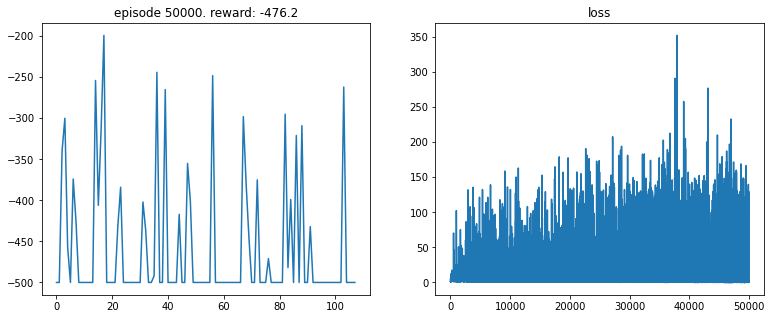

In [273]:
model,all_rewards, losses = train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 50000, batch_size=32, gamma = 0.99, device="cuda:1")

In [ ]:
vdo_path = 'video_rl2/'
if not os.path.exists(vdo_path):
  print("No folder ", vdo_path, 'exist. Create the folder')
  os.mkdir(vdo_path)
  print("Create directory finished")
else:
  print(vdo_path, 'existed, do nothing')

env = Monitor(gym.make("Acrobot-v1"), vdo_path, force=True)

acts = ["-1", "0", "1"]
is_done = False
state = env.reset()
while not is_done:
    q_values = estimator.predict(state)
    action = torch.argmax(q_values).item()
    
    state, reward, is_done, info = env.step(action)
    print("take action: ", acts[action])
    print(state, reward, is_done)
    screen = env.render(mode='rgb_array')

    # plt.imshow(screen)
    # ipythondisplay.clear_output(wait=True)
    # ipythondisplay.display(plt.gcf())
env.close()

## Double Deep Q-Learning (Double DQN)

The Double DQN is is a deep learning version of
the double Q learning algorithm. The idea is to use one DQN for
learning and another DQN to provide the learning targets, making learning
more stable. The double DQN was introduced by, you guessed it, Google DeepMind, again!
You can read the details in [the double DQN paper](https://arxiv.org/pdf/1509.06461.pdf).

The two networks are called the prediction network and the target network. The learning rule is

$$\delta=r+\gamma\max_a Q_T(s',a':\theta_t^-) - Q(s).$$

$Q_T$ is the target generating network, and $Q$ is the prediction network. 

Let's turn back to the last lab (lab 6) and use the CNNDQN class for SpaceInvaders environment

In [19]:
import torchvision.transforms as T
from PIL import Image
image_size = 84

transform = T.Compose([T.ToPILImage(),
                       T.Resize((image_size, image_size), interpolation=Image.CUBIC),
                       T.ToTensor()])

# Convert to RGB image (3 channels)

def get_state2(observation):
    state = observation.transpose((2,0,1))
    state = torch.from_numpy(state)
    state = transform(state)
    return state

/home/alisa/anaconda3/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [6]:
class CNNDQN(nn.Module):
    def __init__(self, n_channel, n_action):
        super(CNNDQN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=n_channel, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.fc1= nn.Linear(7*7*64, 512)
        self.fc2= nn.Linear(512, n_action)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def act(self, state, epsilon):
        # get action from policy action and epsilon greedy
        if random.random() > epsilon: # get action from old q-values
            state   = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
            q_value = self.forward(state)
            q_value = q_value.cpu()
            action  = q_value.max(1)[1].item()            
        else: # get random action
            action = random.randrange(env.action_space.n)
        return action

In [11]:
env_id = 'SpaceInvaders-v0'
env = gym.make(env_id)

device = "cuda:1"

current_model = CNNDQN(3, env.action_space.n).to(device)
target_model = CNNDQN(3, env.action_space.n).to(device)

optimizer = optim.Adam(current_model.parameters())
replay_buffer = ReplayBuffer(1000)

### Update target model weights

In [12]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

# Initialization

update_target(current_model, target_model)

### Modify training step for double DQN

In [13]:
def compute_td_loss_DoubleDQN(current_model, target_model, batch_size, gamma=0.99):     # from input only a model, you must input 2 models: current_model, and target_model
    # get data from replay mode
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # convert to tensors
    # Autograd automatically supports Tensors with requires_grad set to True.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)

    # calculate q-values and next q-values from deeplearning
    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    # double DQN add here
    next_q_state_values = target_model(next_state)
    ############################################################

    # get q-value from propagated action in each step
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    # double DQN different here
    next_q_value     = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    ############################################################################
    # calculate expected q-value from q-function
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # calculate loss value
    loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

### Modify training loop for double DQN

In [21]:
from tqdm import trange

def train_DoubleDQN(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0

    obs = env.reset()
    state = get_state2(obs)
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # get action with q-values
        epsilon = eps_by_episode(episode)
        action = current_model.act(state, epsilon)
        
        # input action into state
        next_obs, reward, done, _ = env.step(action)
        next_state = get_state2(next_obs)
        # save data into buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        
        state = next_state
        obs = next_obs
        episode_reward += reward
        
        if done:
            obs = env.reset()
            state = get_state2(obs)
            all_rewards.append(episode_reward)
            episode_reward = 0
            
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss_DoubleDQN(current_model, target_model, batch_size, gamma)    #######
            losses.append(loss.item())

        if episode % 500 == 0: # update target_model weight. The '500' is hyperparameter, you can change it as you want
            update_target(current_model, target_model)
            
    plot(episode, all_rewards, losses)  
    return current_model, target_model, all_rewards, losses

### Let's train

Agent training (episode1) Avg Reward 0.0:   0%|          | 0/50001 [00:00<?, ?it/s]<ipython-input-13-7ae0234ad0cb>:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
Agent training (episode48) Avg Reward 0.0:   0%|          | 39/50001 [00:00<07:06, 117.06it/s]<ipython-input-6-89f54e8c09a1>:24: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state   = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
Agent training (episode50001) Avg Reward 0.23119537609247814: 100%|██████████| 50001/50001 [06:26<00:00, 129.50it/s]


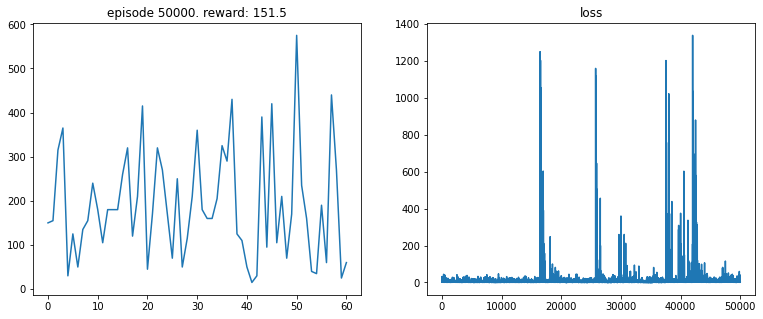

In [24]:
current_model, target_model, all_rewards, losses = train_DoubleDQN(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, episodes = 50000, batch_size=32, gamma = 0.99)

See the result

In [36]:
import os
from gym.wrappers import Monitor

vdo_path = 'video_rl_ddqn/'
if not os.path.exists(vdo_path):
  print("No folder ", vdo_path, 'exist. Create the folder')
  os.mkdir(vdo_path)
  print("Create directory finished")
else:
  print(vdo_path, 'existed, do nothing')

env = Monitor(gym.make(env_id), vdo_path, force=True)

is_done = False
state = env.reset()
state = get_state2(state)
while not is_done:
    action = current_model.act(state, epsilon_final)
    next_obs, reward, is_done, _ = env.step(action)
    next_state = get_state2(next_obs)
    screen = env.render(mode='rgb_array')

    # plt.imshow(screen)
    # ipythondisplay.clear_output(wait=True)
    # ipythondisplay.display(plt.gcf())
    state = next_state
env.close()

video_rl_ddqn/ existed, do nothing


<ipython-input-6-89f54e8c09a1>:24: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state   = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)


## Dueling DQN or the real DDQNs

When you think about dueling, it must be Dread Pirate Roberts and Enigo Montoya...

<img src="img/RL2_DDQN.png" title="" style="width: 600px;" />

Oops!!! sorry, just kidding ;P

### What is DDQNs?

To see the details, read the [Dueling DQNs (DDQNs) paper](https://arxiv.org/abs/1511.06581).

DDQNs are different from the double DQNs. Both variations assume some form of duality,
but while double DQN has two separate models, the DDQN is one model split at the base.

<img src="img/RL2_DDQN3.png" title="" style="width: 800px;" />

DDQN extends the concept of a fixed Q target and extends that to a concept called *advantage*.
The advantage indicates what additional value one action has against other actions.
The Q-value in DDQNs is computed with the following two functions:

$$Q(s,a)=V(s)+A(s,a)-\frac{1}{|A|}\sum_{a'=1}^{|A|} A(s,a')$$

 - $V(s)$: state-value function, the value of being in state $s$
 - $A(s,a)$: state-dependent action advantage function, estimating how much better it is to take an action $a$ than other actions $a'$ in the same state

In [37]:
class DDQN(nn.Module):
    def __init__(self, n_channel, n_action):
        super(DDQN, self).__init__()        
        
        self.conv1 = nn.Conv2d(in_channels=n_channel, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        
        # advantage layer: output is n_action as usual
        self.advantage = nn.Sequential(
            nn.Linear(7*7*64, 128),
            nn.ReLU(),
            nn.Linear(128, n_action)
        )
        
        # policy value: value action
        self.value = nn.Sequential(
            nn.Linear(7*7*64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        advantage = self.advantage(x)
        value     = self.value(x)

        # recalculate Q-value
        return value + advantage - advantage.mean()
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [38]:
env_id = 'SpaceInvaders-v0'
env = gym.make(env_id)

current_model = DDQN(3, env.action_space.n).to(device)
target_model = DDQN(3, env.action_space.n).to(device)

optimizer = optim.Adam(current_model.parameters())
replay_buffer = ReplayBuffer(1000)

update_target(current_model, target_model)

Agent training (episode33) Avg Reward 0.0:   0%|          | 0/50001 [00:00<?, ?it/s]<ipython-input-13-7ae0234ad0cb>:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
Agent training (episode59) Avg Reward 0.0:   0%|          | 52/50001 [00:00<03:38, 228.34it/s]<ipython-input-37-dc51b58d6d0d>:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state   = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
Agent training (episode50001) Avg Reward 0.20849583008339834: 100%|██████████| 50001/50001 [07:04<00:00, 117.77it/s]


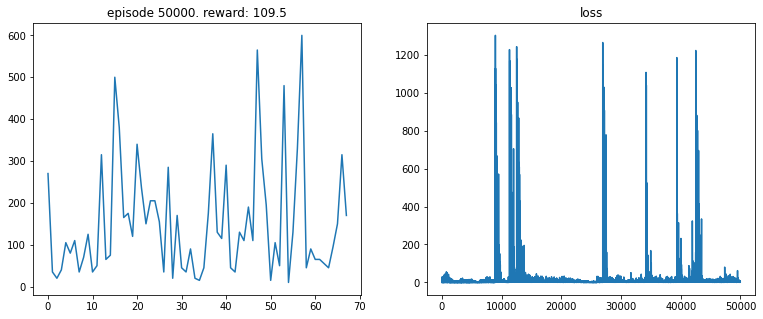

In [39]:
current_model, target_model, all_rewards, losses = train_DoubleDQN(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, episodes = 50000, batch_size=32, gamma = 0.99)

In [40]:
import os
from gym.wrappers import Monitor

vdo_path = 'video_rl_dueldqn/'
if not os.path.exists(vdo_path):
  print("No folder ", vdo_path, 'exist. Create the folder')
  os.mkdir(vdo_path)
  print("Create directory finished")
else:
  print(vdo_path, 'existed, do nothing')

env = Monitor(gym.make(env_id), vdo_path, force=True)

is_done = False
state = env.reset()
state = get_state2(state)
while not is_done:
    action = current_model.act(state, epsilon_final)
    next_obs, reward, is_done, _ = env.step(action)
    next_state = get_state2(next_obs)
    screen = env.render(mode='rgb_array')

    # plt.imshow(screen)
    # ipythondisplay.clear_output(wait=True)
    # ipythondisplay.display(plt.gcf())
    state = next_state
env.close()

No folder  video_rl_dueldqn/ exist. Create the folder
Create directory finished


<ipython-input-37-dc51b58d6d0d>:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state   = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)


## Prioritized experience replay

The replay buffer or experience replay mechanism allows us to values in batches at a later time in order to train the network.
Up till now, our batches are random samples from the buffer.
However, some samples would be better than others, so we don't need to store everything. We can make two decisions:
 - What data to store
 - What priority to use

Let's develop a version of the replay buffer that tracks priority from experience replay,
so we can predict where the agent should spend its learning capacity.

In [41]:
class NaivePrioritizedBuffer(object):
    def __init__(self, capacity, prob_alpha=0.6):
        self.prob_alpha = prob_alpha
        self.capacity   = capacity
        self.buffer     = []
        self.pos        = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
    
    def push(self, state, action, reward, next_state, done):
        assert state.ndim == next_state.ndim
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        # check maximum priority
        max_prio = self.priorities.max() if self.buffer else 1.0
        
        # add it or replace it
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        
        # calculate priority
        probs  = prios ** self.prob_alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        
        total    = len(self.buffer)
        weights  = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights  = np.array(weights, dtype=np.float32)
        
        batch       = list(zip(*samples))
        states      = np.concatenate(batch[0])
        actions     = batch[1]
        rewards     = batch[2]
        next_states = np.concatenate(batch[3])
        dones       = batch[4]
        
        return states, actions, rewards, next_states, dones, indices, weights
    
    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(list(batch_indices), [batch_priorities]):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)

In [44]:
def compute_td_loss_DDQN_prior_exp_replay(current_model, target_model, batch_size, gamma=0.99, beta=0.4):
    # get data from replay mode
    # state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    state, action, reward, next_state, done, indices, weights = replay_buffer.sample(batch_size, beta)

    # convert to tensors
    # Autograd automatically supports Tensors with requires_grad set to True.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)
    weights    = autograd.Variable(torch.FloatTensor(weights)).to(device)

    # calculate q-values and next q-values from deeplearning
    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    # double DQN add here
    #next_q_state_values = target_model(next_state)

    # get q-value from propagated action in each step
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    # double DQN different here
    #next_q_value     = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    # calculate expected q-value from q-function
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # calculate loss value
    # loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
    loss = (q_value - expected_q_value.detach()).pow(2).mean()
    prios = loss + 1e-5
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    replay_buffer.update_priorities(indices, prios.data.cpu().numpy())
    optimizer.step()

    return loss

### Importance-sampling

Here we define a value $\beta$ indicating the importance of experience, focusing more on the recent experience
than on outdated experience:


In [42]:
episodes = 200000
batch_size = 64
gamma      = 0.99
min_play_reward = -.15

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = episodes / 10
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

# defind a function to return an increasing beta over episodes
beta_start = 0.4
beta_episodes = episodes / 10
def gen_beta_by_episode(beta_start, beta_episodes):
    beta_by_episode = lambda episode: min(1.0, beta_start + episode * (1.0 - beta_start) / beta_episodes)
    return beta_by_episode

beta_by_episode = gen_beta_by_episode(beta_start, beta_episodes)

### Let's start train

In [45]:
def train_DDQN_prior_exp_replay(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, beta_by_episode, episodes = 10000, batch_size=32, gamma = 0.99, min_play_reward=-.15):
    losses = []
    all_rewards = []
    episode_reward = 0

    obs = env.reset()
    state = get_state2(obs)
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)
    for episode in tr:
        avg_reward = tot_reward / (episode + 1)
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,avg_reward))
        tr.refresh() 

        # get action with q-values
        epsilon = eps_by_episode(episode)
        action = current_model.act(state, epsilon)
        
        # input action into state
        next_obs, reward, done, _ = env.step(action)
        next_state = get_state2(next_obs)
        # save data into buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        
        state = next_state
        obs = next_obs
        episode_reward += reward
        
        if done:
            obs = env.reset()
            state = get_state2(obs)
            all_rewards.append(episode_reward)
            episode_reward = 0
            
        if len(replay_buffer) > batch_size:
            beta = beta_by_episode(episode)
            loss = compute_td_loss_DDQN_prior_exp_replay(current_model, target_model, batch_size, gamma, beta)
            losses.append(loss.item())

        if episode % 500 == 0:
            update_target(current_model, target_model)
            
    plot(episode, all_rewards, losses)  
    return current_model, target_model, all_rewards, losses

In [43]:
env_id = 'SpaceInvaders-v0'
env = gym.make(env_id)

current_model = DDQN(3, env.action_space.n).to(device)
target_model  = DDQN(3, env.action_space.n).to(device)

optimizer = optim.Adam(current_model.parameters())

# Change from Normal replay buffer to be prioritize buffer
#replay_buffer = ReplayBuffer(100000)
replay_buffer = NaivePrioritizedBuffer(100000)

update_target(current_model, target_model)

In [ ]:
current_model, target_model, all_rewards, losses = train_DDQN_prior_exp_replay(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, beta_by_episode, episodes = episodes, batch_size=batch_size, gamma = gamma, min_play_reward = min_play_reward)

Agent training (episode65) Avg Reward 0.0:   0%|          | 59/200001 [00:00<05:42, 583.20it/s]<ipython-input-44-a80320534747>:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
Agent training (episode255) Avg Reward 0.11764705882352941:   0%|          | 254/200001 [00:02<36:28, 91.28it/s]  <ipython-input-37-dc51b58d6d0d>:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state   = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
Agent training (episode182614) Avg Reward 0.30597325506259104:  91%|█████████▏| 182611/200001 [39:02<04:32, 63.73it/s]

In [ ]:
import os
from gym.wrappers import Monitor

vdo_path = 'video_rl_prioritize_dueldqn/'
if not os.path.exists(vdo_path):
  print("No folder ", vdo_path, 'exist. Create the folder')
  os.mkdir(vdo_path)
  print("Create directory finished")
else:
  print(vdo_path, 'existed, do nothing')

env = Monitor(gym.make(env_id), vdo_path, force=True)

is_done = False
state = env.reset()
state = get_state2(state)
while not is_done:
    action = current_model.act(state, epsilon_final)
    next_obs, reward, is_done, _ = env.step(action)
    next_state = get_state2(next_obs)
    screen = env.render(mode='rgb_array')

    # plt.imshow(screen)
    # ipythondisplay.clear_output(wait=True)
    # ipythondisplay.display(plt.gcf())
    state = next_state
env.close()

## Lab exercise

1. Select one environment and implement it in FA with **DDQN, and Duel-DQNs**:
- InvertedDoublePendulum-v2
- BipedalWalker-v2

And submit with vdos of DDQN and Duel-DQNs.

Do the best as you think you can do. For example, add the frames, change the rewards, or create some inspiration of FA function.